In [1]:
# Cell 1: Imports and Setup
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display as ld
import librosa.feature as lf

from src.data_loader import DataLoader
from src.pre_processing import PreProcessor
from src.feature_extraction import FeatureExtractor
from src.cache_manager import CacheManager
from config.config import Config

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
config = Config()
FEATURE_SET = "baseline" # "baseline" or "xgb"

loader = DataLoader()
preprocessor = PreProcessor()
feature_extractor = FeatureExtractor(feature_set=FEATURE_SET)
cache = CacheManager()

metadata = loader.load_metadata()

In [3]:
sample_files = {}

for class_id, class_name in enumerate(config.CLASS_NAMES):
    row = metadata[metadata['classID'] == class_id].iloc[0]
    audio_path = loader.get_audio_path(row['slice_file_name'], row['fold'])

    audio, sr = preprocessor.load_and_preprocess(audio_path)

    sample_files[class_name] = {
        'audio': audio,
        'sr': sr,
        'filename': row['slice_file_name']
    }

print("Loaded 1 preprocessed sample per class")
print(f"Target SR: {config.TARGET_SR} Hz | Duration: {config.DURATION}")

Loaded 1 preprocessed sample per class
Target SR: 16000 Hz | Duration: 4.0


In [4]:
mfcc_data = {}

for class_name, data in sample_files.items():
    mfcc = lf.mfcc(
        y=data['audio'],
        sr=data['sr'],
        n_mfcc=config.N_MFCC,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH
    )

    mfcc_data[class_name] = mfcc
    print(f"MFCC: {class_name} ({len(mfcc)} MFCCs)")

MFCC: air_conditioner (40 MFCCs)
MFCC: car_horn (40 MFCCs)
MFCC: children_playing (40 MFCCs)
MFCC: dog_bark (40 MFCCs)
MFCC: drilling (40 MFCCs)
MFCC: engine_idling (40 MFCCs)
MFCC: gun_shot (40 MFCCs)
MFCC: jackhammer (40 MFCCs)
MFCC: siren (40 MFCCs)
MFCC: street_music (40 MFCCs)


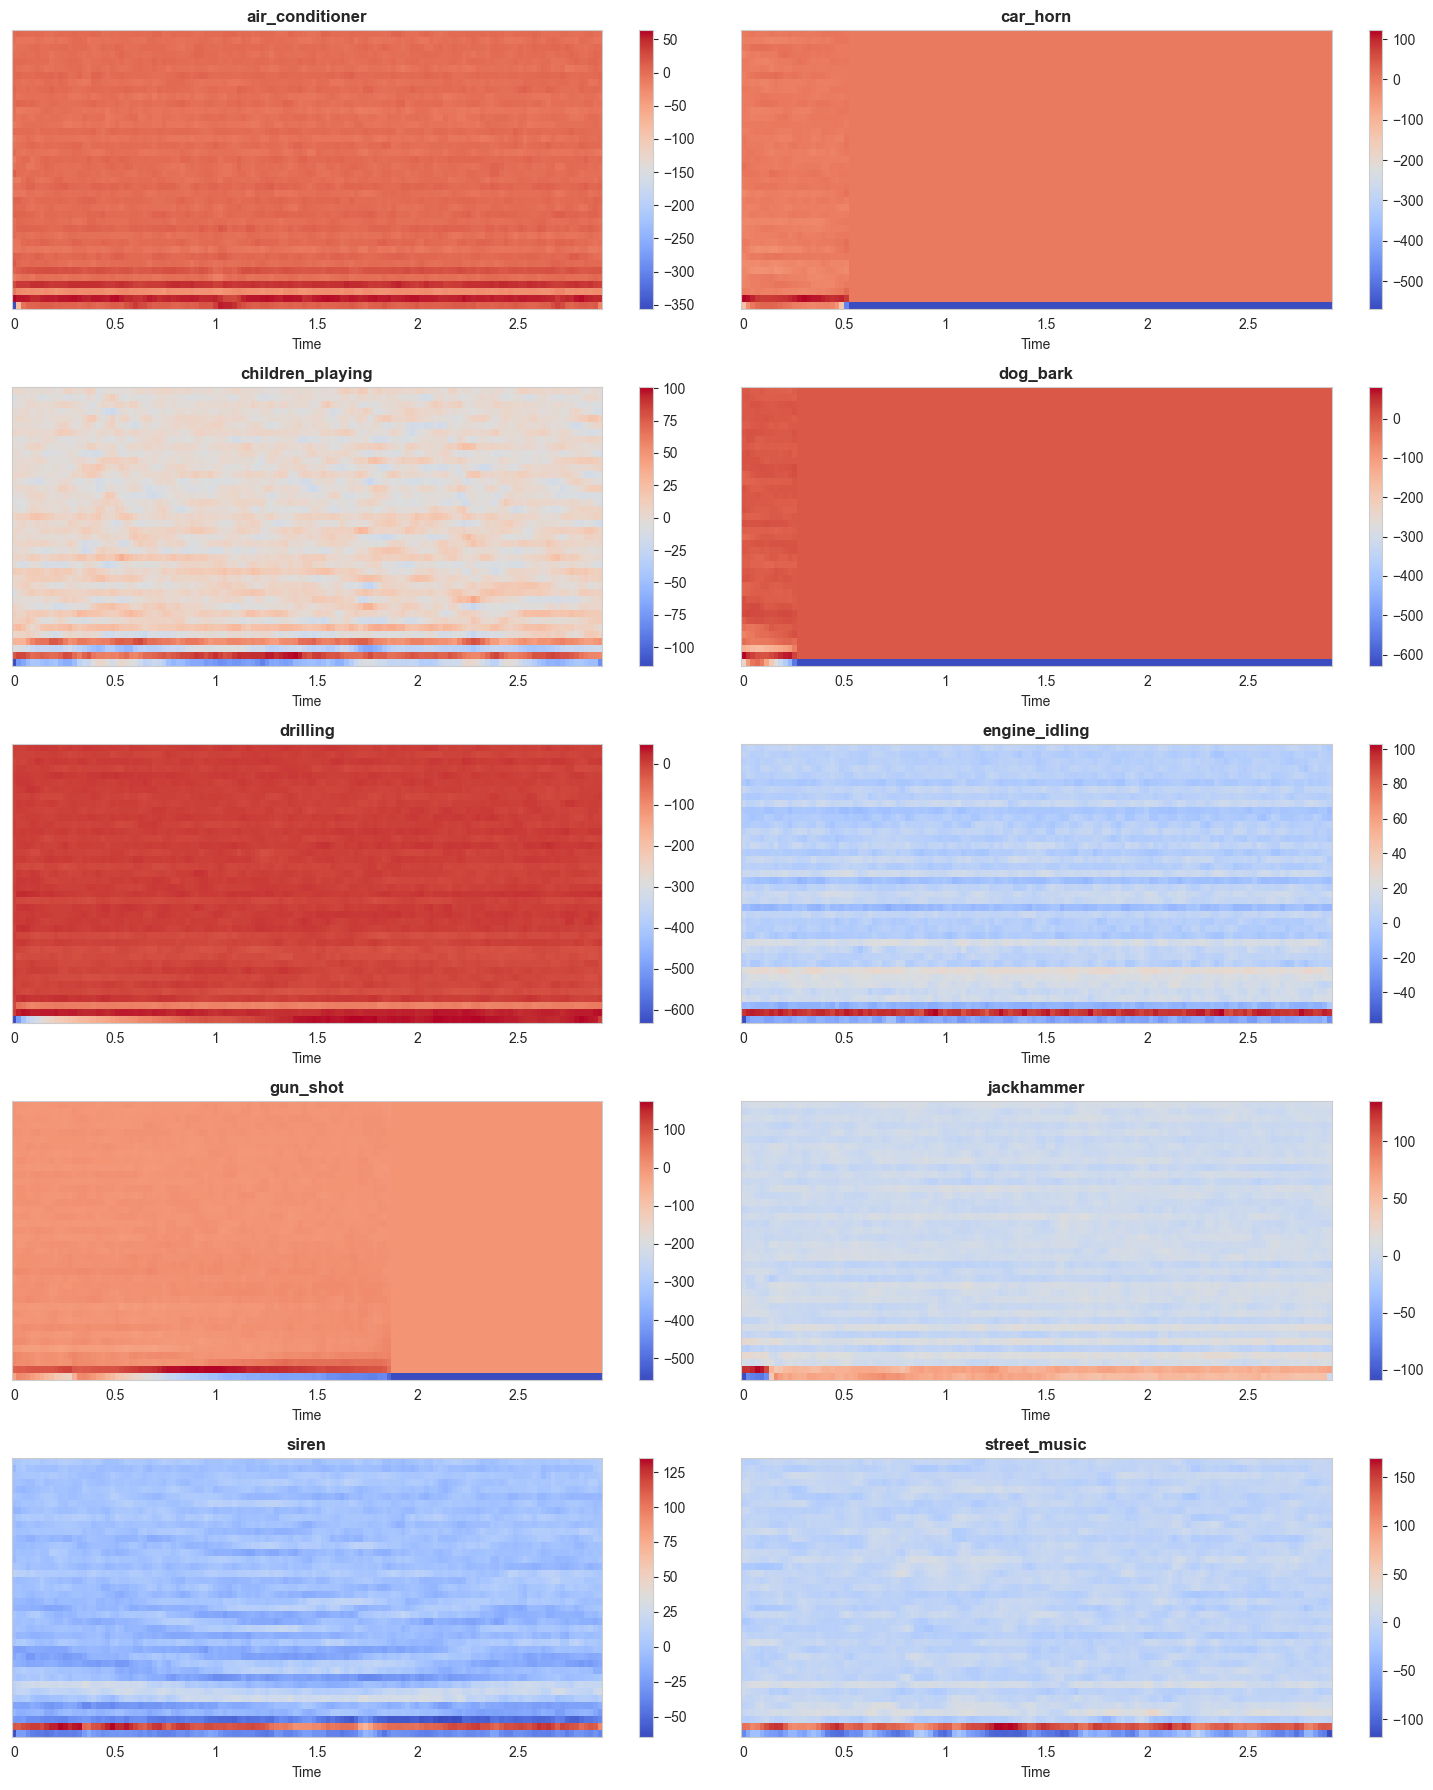

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(15, 18))
axes = axes.flatten()

for idx, (class_name, mfcc) in enumerate(mfcc_data.items()):
    img = ld.specshow(
        mfcc,
        x_axis='time',
        ax=axes[idx],
        cmap='coolwarm'
    )
    axes[idx].set_title(class_name, fontweight='bold')
    plt.colorbar(img, ax=axes[idx])

plt.tight_layout()
plt.show()

In [6]:
feature_vectors = {}

for class_name, data in sample_files.items():
    features = feature_extractor.extract_features(data['audio'], data['sr'])
    feature_vectors[class_name] = features
    print(f"{class_name:20s}: {len(features)} features")

print(f"\nTotal features per sample: {len(features)}")

air_conditioner     : 88 features
car_horn            : 88 features
children_playing    : 88 features
dog_bark            : 88 features
drilling            : 88 features
engine_idling       : 88 features
gun_shot            : 88 features
jackhammer          : 88 features
siren               : 88 features
street_music        : 88 features

Total features per sample: 88


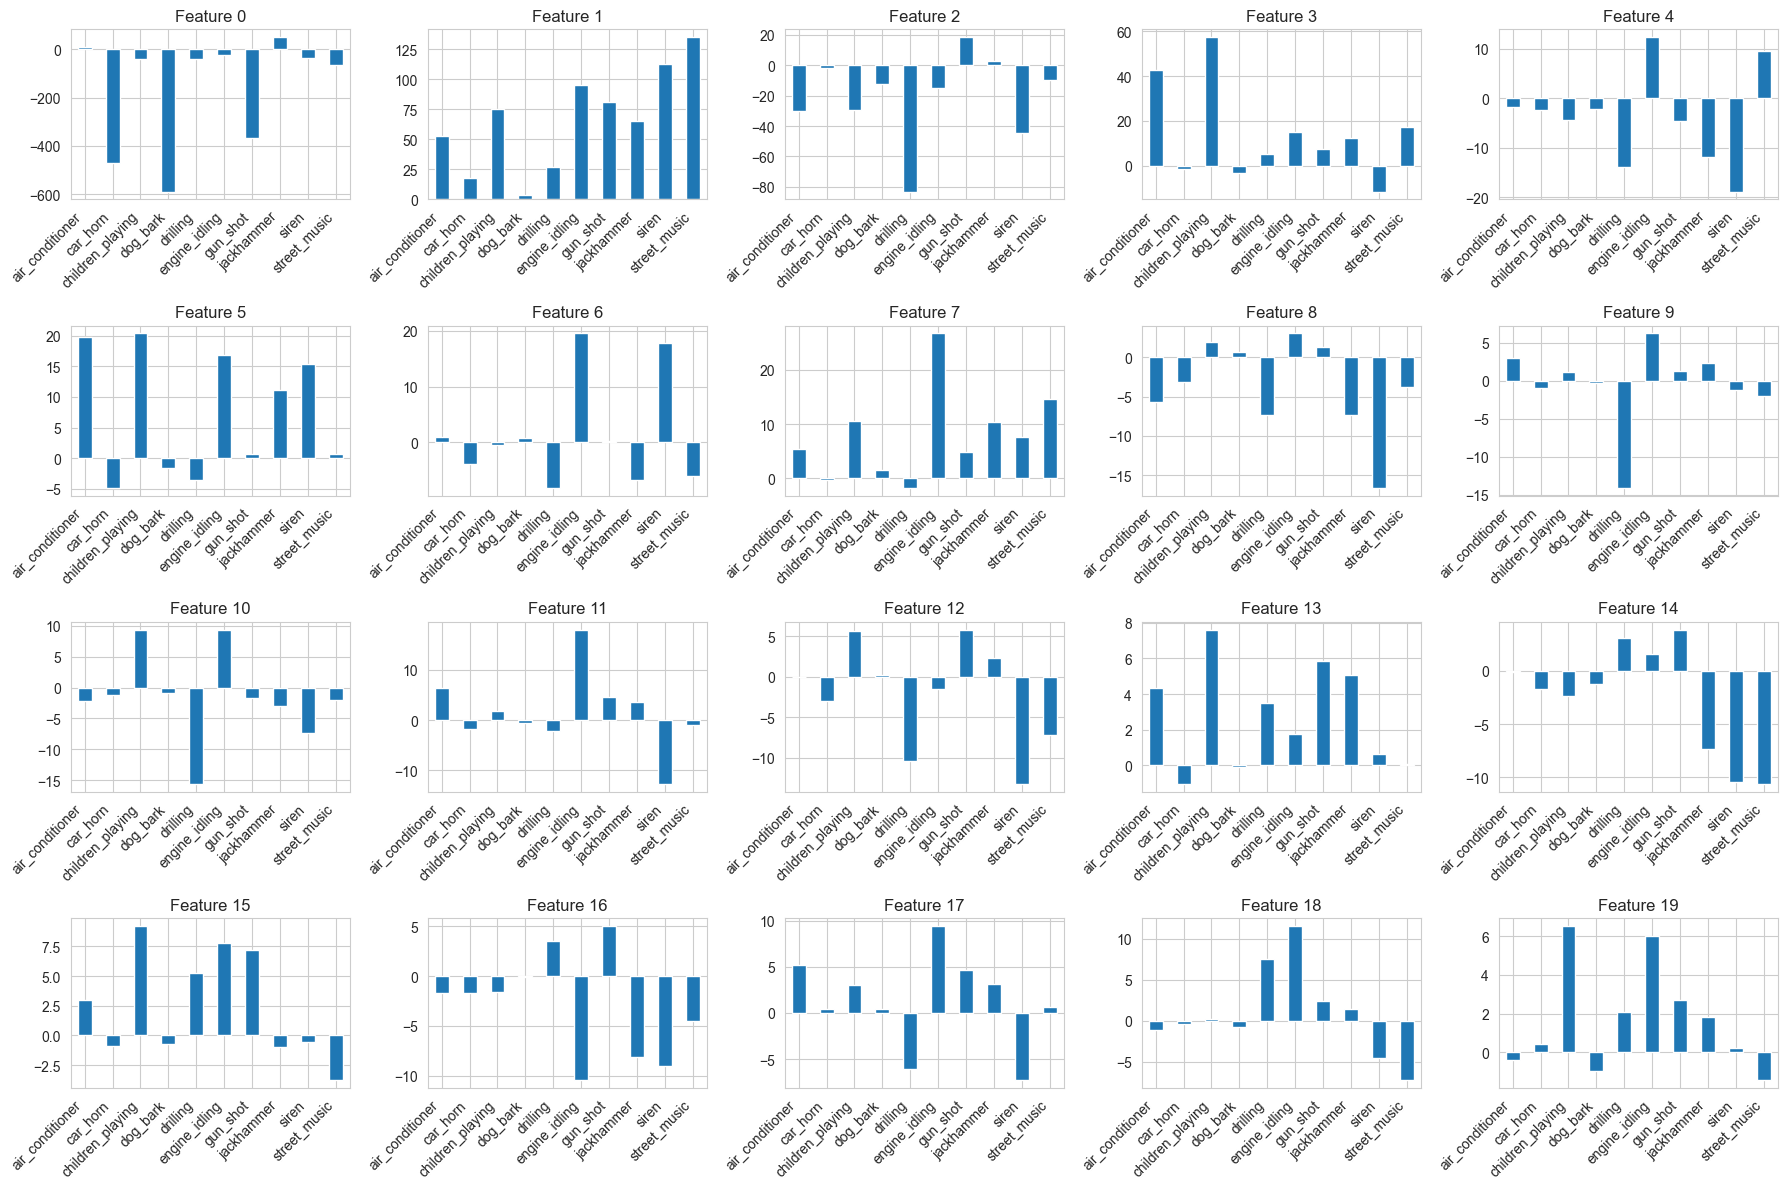

In [7]:
feature_df = pd.DataFrame(feature_vectors).T
feature_df.columns = [f"feature_{idx}" for idx in range(feature_df.shape[1])]

fig, axes = plt.subplots(4, 5, figsize=(18, 12))
axes = axes.flatten()

for i in range(20):
    feature_df.iloc[:, i].plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Feature {i}")
    axes[i].set_xticklabels(feature_df.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

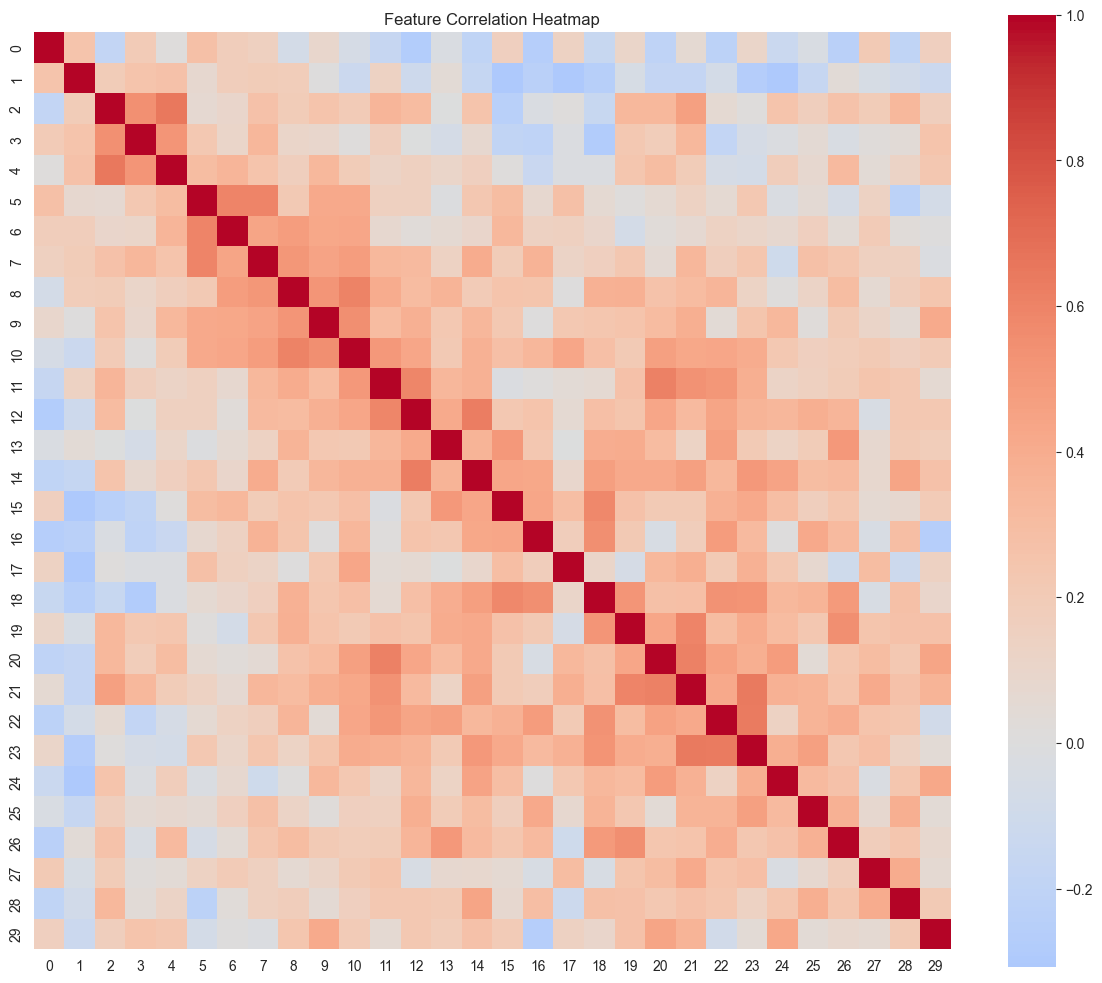

In [10]:
X = []
Y = []

sample_rows = metadata.sample(50, random_state=42)

for _, row in sample_rows.iterrows():
    audio_path = loader.get_audio_path(row['slice_file_name'], row['fold'])

    cached = cache.load_cached_features(audio_path, FEATURE_SET)
    if cached is None:
        audio, sr = preprocessor.load_and_preprocess(audio_path)
        features = feature_extractor.extract_features(audio, sr)
        cache.save_cached_features(audio_path, FEATURE_SET, features)
    else:
        features = cached

    X.append(features)
    Y.append(row['classID'])

X = np.array(X)

corr = np.corrcoef(X.T)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr[:30,:30],
    cmap='coolwarm',
    center=0,
    square=True
)

plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [11]:
print("=" * 60)
print("FEATURE EXTRACTION SUMMARY")
print("=" * 60)
print(f"Feature set: {FEATURE_SET}")
print(f"Total features per sample: {len(features)}")
print(f"Target SR: {config.TARGET_SR}")
print(f"Duration: {config.DURATION}s")
print(f"N_MFCC: {config.N_MFCC}")
print(f"N_FFT: {config.N_FFT}")
print(f"HOP_LENGTH: {config.HOP_LENGTH}")
print("=" * 60)


FEATURE EXTRACTION SUMMARY
Feature set: baseline
Total features per sample: 88
Target SR: 16000
Duration: 4.0s
N_MFCC: 40
N_FFT: 2048
HOP_LENGTH: 512
